In [1]:
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx

from google3.util.operations_research.cloud.lattle.experiments import graph_utils, mdp

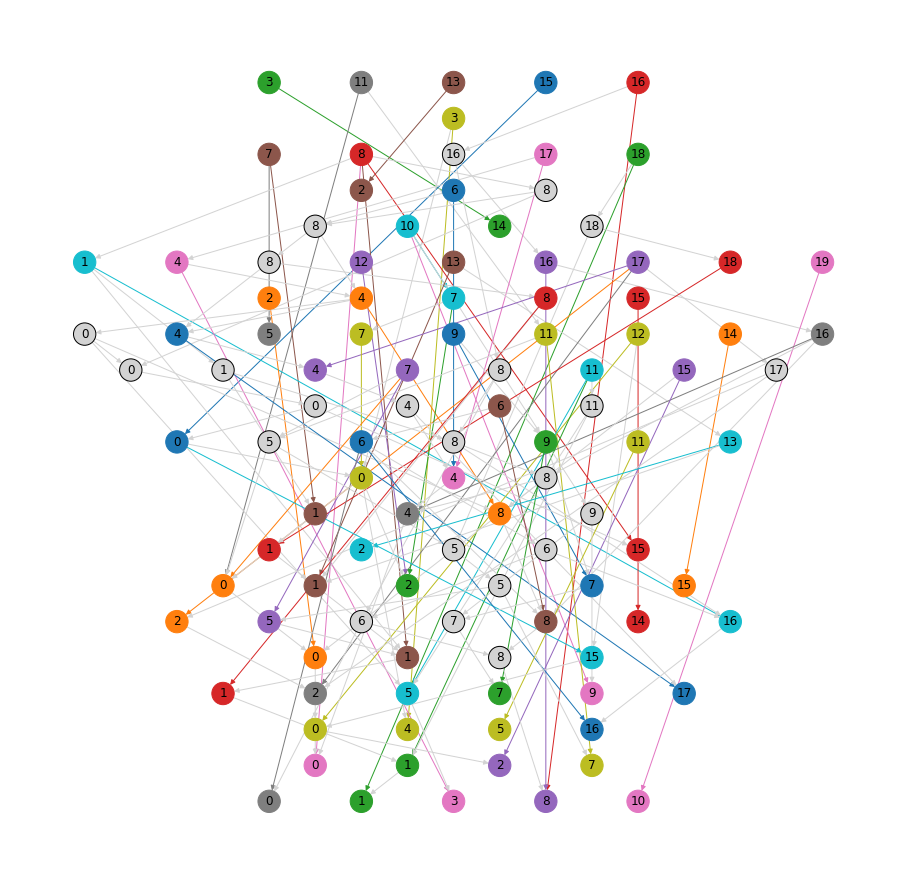

In [11]:
scale_factor = 0.8  # Plotting scale
num_hubs = 20  # Number of depots in the network.
timesteps = 20  # Number of time steps.
num_parcels = 50  # Number of parcels.

# Create middle-mile environment and initialize state.
env = mdp.MiddleMileMDP(
    num_hubs=num_hubs,
    timesteps=timesteps,
    num_trucks_per_step=num_hubs,
    max_truck_duration=timesteps // 2,
    num_parcels=num_parcels,
    mean_route_length=timesteps // 2,
    cut_capacities=1
)
rng = np.random.default_rng(42)
state = env.reset(rng)

# Plot state.
fig, ax = plt.subplots(figsize=(num_hubs * scale_factor, timesteps * scale_factor))
graph_utils.draw_network(state, ax)

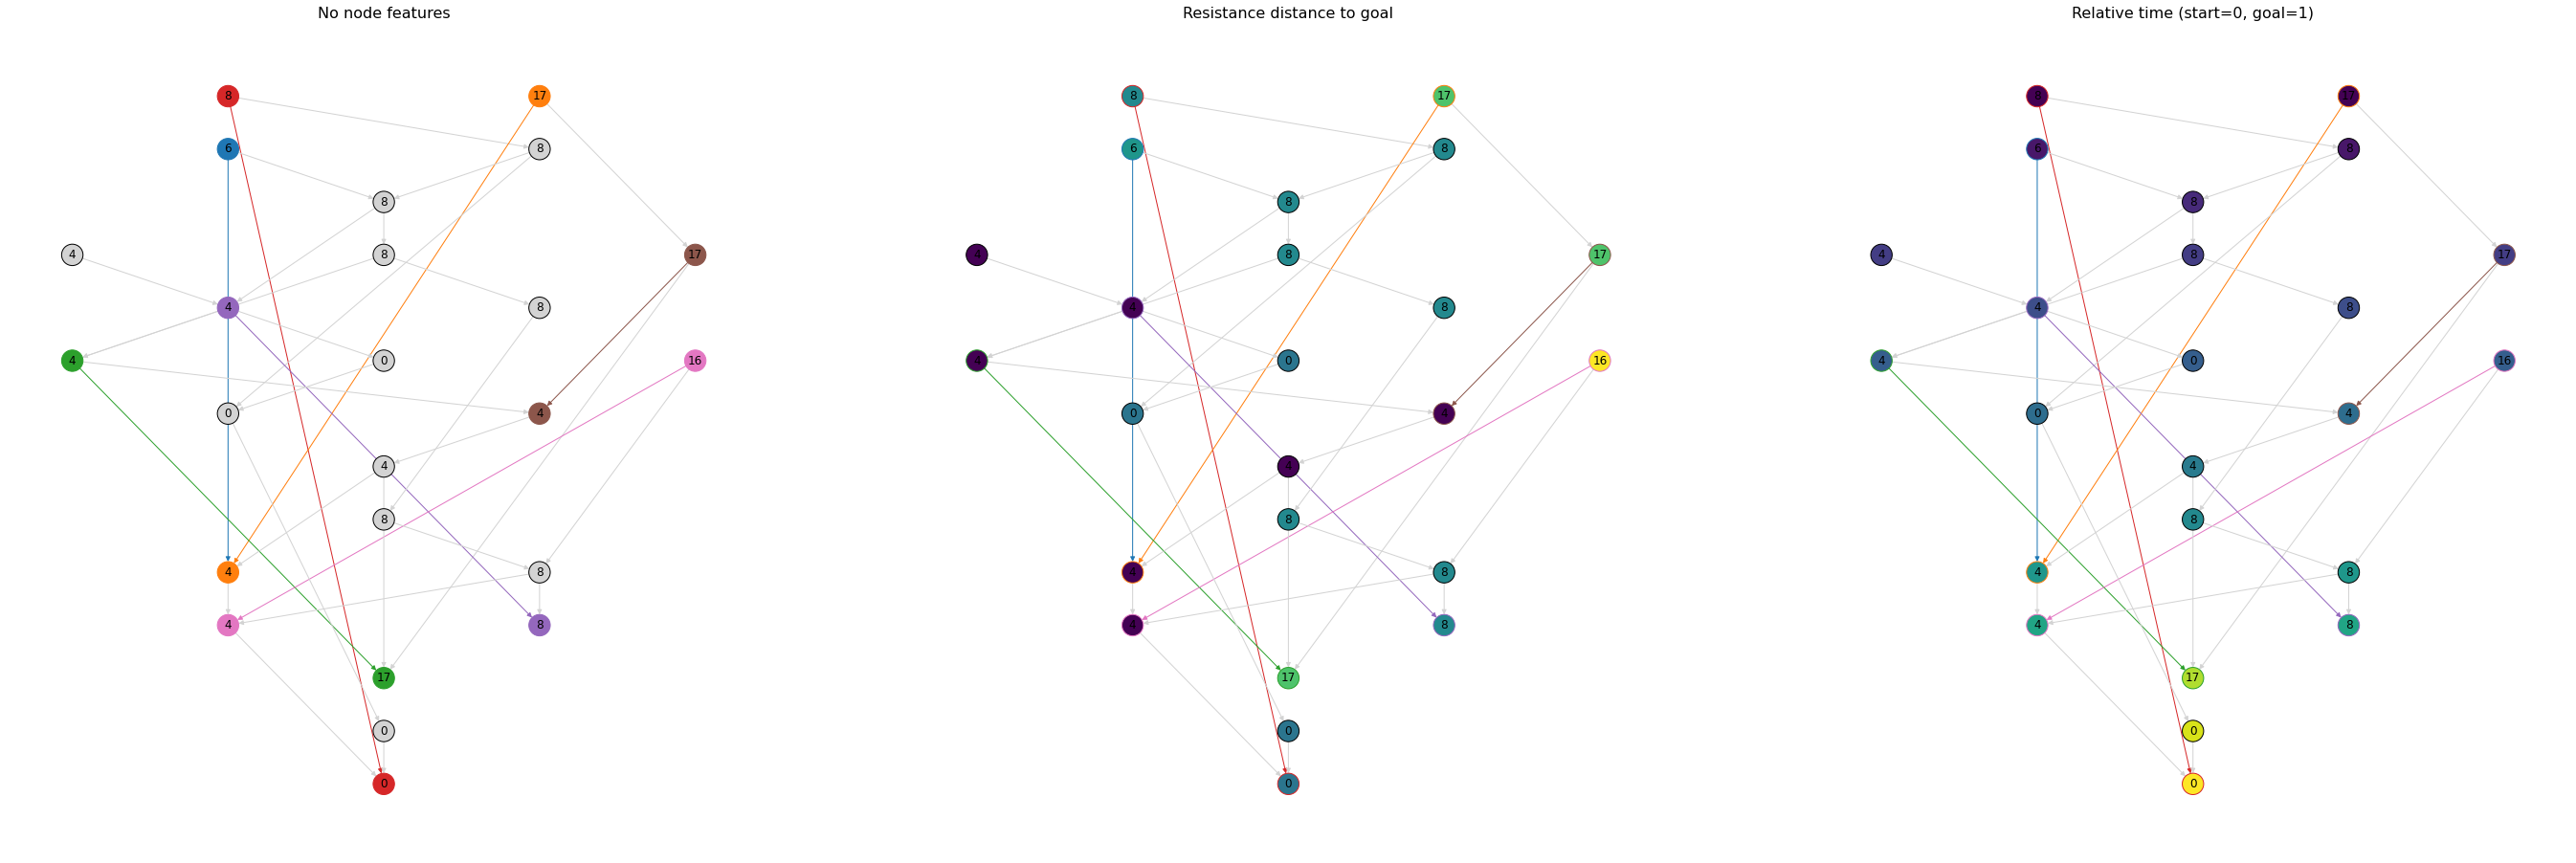

In [13]:
# Show 3-step feature graph for first parcel.
parcel = np.where(state.edges[:, graph_utils.EdgeFeatures.PARCEL_FORWARD] == 1)[0][0]
_, feature_graph, *_ = env.get_feature_graph(3, state, parcel)
fig, ax = plt.subplots(1, 3, figsize=(3 * num_hubs * scale_factor, timesteps * scale_factor))
plt.rcParams['axes.titlesize'] = 16
ax[0].set_title("No node features")
ax[1].set_title("Resistance distance to goal")
ax[2].set_title("Relative time (start=0, goal=1)")
graph_utils.draw_network(feature_graph, ax[0])
graph_utils.draw_network(feature_graph, ax[1], node_feature=2)
graph_utils.draw_network(feature_graph, ax[2], node_feature=3)

In [16]:
# Rollout with random policy.
rng = np.random.default_rng(42)
state = env.reset(rng)
states = [state]
deliveries = 0
while True:
  # Get next parcel and available trucks.
  state, parcel, trucks = env.get_actions(state)
  if parcel is None:
    break

  # Put parcel onto first truck, get next state.
  truck = rng.choice(trucks)
  state, is_delivered, _ = env.step(parcel, truck, state)
  states.append(state)
  deliveries += is_delivered

print(f"Deliveries using the random policy: {deliveries} / {num_parcels}.")

Deliveries using the random policy: 48 / 50.


In [21]:
# Rollout with simple greedy resistance-distance policy.
state = env.reset(np.random.default_rng(42))
states = [state]
deliveries = 0
while True:
  # Get feature graph and actions.
  state, feature_graph, parcel_tuple, actions = env.get_feature_graph(1, state)
  if feature_graph is None:
    break
  parcel, _ = parcel_tuple

  # Put parcel onto truck which minimizes distance to goal.
  action = min(
      actions,
      key=lambda action: feature_graph.nodes[feature_graph.receivers[action], 2]
  )
  truck = actions[action]

  # Get next state.
  state, is_delivered, _ = env.step(parcel, truck, state)
  states.append(state)
  deliveries += is_delivered

print(f"Deliveries using the simple greedy resistance-distance policy: {deliveries} / {num_parcels}.")

Deliveries using the simple greedy resistance-distance policy: 49 / 50.
